# Finding Heavy Traffic Indicators on I-94
    

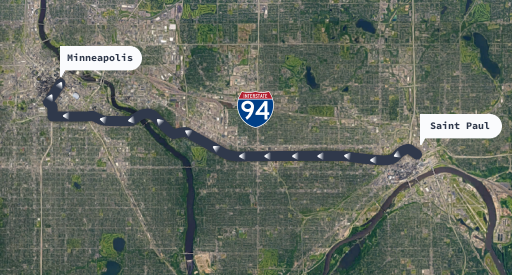


__[Interstate 94 (I-94)](https://en.wikipedia.org/wiki/Interstate_94)__ is an east-west interstate highway of the US. It begins at Billings, Montana and ends at Port Huron, Michigan. 

This project analyses the dataset about westbound traffic on this I-94. The dataset can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume). The goals is to determine a few of indicators of heavy traffic on I-94, some possible indicators are: weatther, seasons, peak hours etc. We will implement some data cleaning and data visualization techniques in thisp project.

One thing to note that the dataset was recorded from 2 stations: one at **Saint Paul** and the other end is at **Minneapolis**. 

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## Explore dataset

In [3]:
traffic = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
traffic.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [5]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


There are __9__ columns and **48204** entries in each entry is an hourly record of traffic volume on a specific day. The entire dataset is a record from 2012-10-2 to 2018-09-30. There are no missing values in the dataset.

The following table summarizes all the columns:

|**Column**|**Description**|**Data Type**|
| :- | :-- | --- |
|holiday      |US National holidays plus regional holiday, Minnesota State Fair| Categorical|
|temp         | Average temp in K                                               | float |
|rain_1h      | Amount in mm of rain that occurred in the hour                  | float |
|snow_1h      | Amount in mm of snow that occurred in the hour                  | float |
|clouds_all   |  Percentage of cloud cover                                      | int   |
|weather_main |Short textual description of the current weather                 | Object|
|weather_description|Longer textual description of the current weather          | Object|
|date_time    |  Hour of the data collected in local CST time                   | Object|
|traffic_volume| Hourly I-94 ATR 301 reported westbound traffic volume          | int|


Our target is __traffic_volume__ column which were recorded by [Automatic Traffic Recorder(ATR)](https://miovision.com/blog/traffic-data-types) stations that capture the number of vehicle passing by the stations over a period of time.

## Explore the target columns (traffic_volume)

Let's first print out some statistical measurements and plot the distribution of our target

In [6]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Text(0.5, 0, 'traffic_volume')

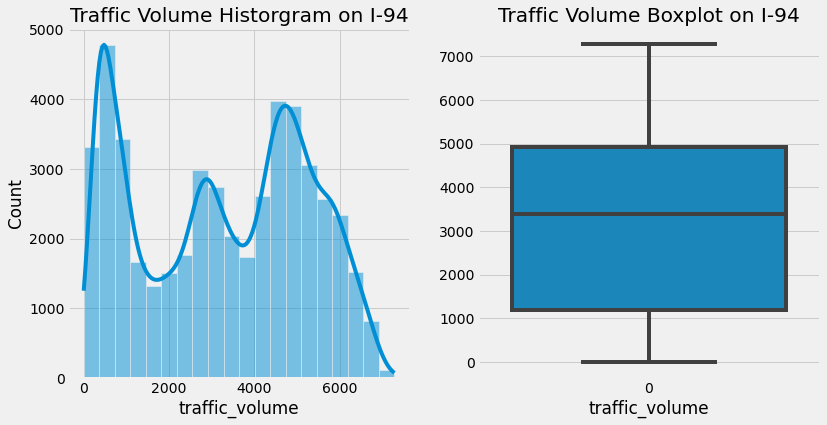

In [7]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
ax = sns.histplot(traffic['traffic_volume'], bins=20, kde=True)
ax.set_title("Traffic Volume Historgram on I-94")

fig.add_subplot(1,2,2)
ax2 = sns.boxplot(data=traffic['traffic_volume'])
ax2.set_title("Traffic Volume Boxplot on I-94")
ax2.set_xlabel('traffic_volume')

**A few observations**:
- The maximum traffic volume is 7280 and the minimum is 0 i.e there were not a single vehicle passing by.
- The distribution of traffic volume is far from normal.
- There are no outliers (unsually high or low_) in the dataset.
- About 25% of the time, there are 1193 cars or fewer passing by the stations.
- Another 25% of the time, there are somewhere between 4933 and 7280 cars passing by.


We now dive into investigating what factors affect the traffic volume. We will start with the time in the day.

## Examine daytime and nighttime on traffic

We'll start dividing the dataset into 2 parts base on the hour of that day:
* Daytime :7AM - 7PM (or 7-19)
* Nighttime: 7PM - 7AM (or 19-23 and 0-7)

This is not a perfect criterion but let's start from here.

In [8]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic['hour'] = traffic['date_time'].dt.hour #Extract the hour 
daytime = traffic[(traffic['hour'] >= 7) & (traffic['hour'] < 19)]
nighttime = traffic[(traffic['hour'] < 7) | (traffic['hour'] >= 19)]

In [9]:
daytime.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13


In [10]:
nighttime.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543,19
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781,20
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159,21
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450,22
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954,23


Let's plot the distribution of traffic volume w.r.t each period of the day.

Text(0.5, 0.98, 'Traffic Volume distribution during daytime and nighttime')

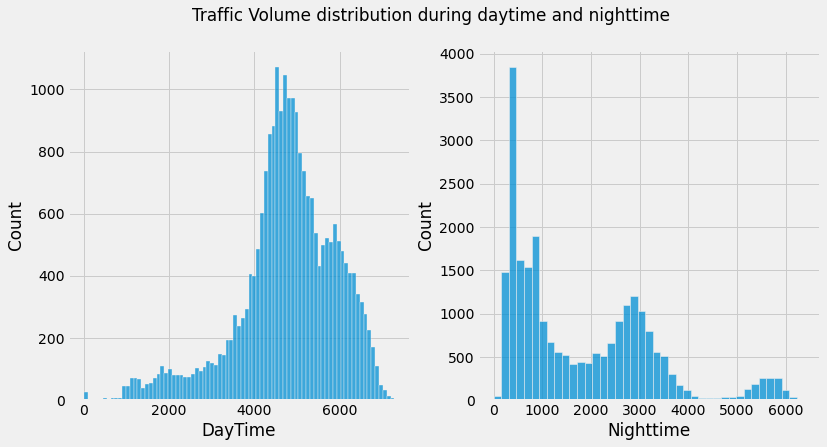

In [11]:
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
#fig.add_subplot(1,2,1)
ax1 = sns.histplot(daytime['traffic_volume'])
ax1.set_xlabel('DayTime')

plt.subplot(1,2,2)
#fig.add_subplot(1,2,2)
ax2 = sns.histplot(nighttime['traffic_volume'])
ax2.set_xlabel('Nighttime')

fig.suptitle('Traffic Volume distribution during daytime and nighttime')

In [12]:
daytime['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [13]:
nighttime['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

**Observations**
- There are much more cars during daytime than nighttime. Daytime mean traffic volume is about 4762 cars whereas nighttime mean traffic volume is about 1785 cars 

- Daytime distribution is more similar to a normal one (std = 1174) whereas nighttime distribution is not normal with quite wide spread across the spectrum (std = 1441)

Since we are interested in heavy traffic indicators, we will move forward on analyzing __daytime__ data **only**.

## Daytime- Traffic vs each month

People might be on the road in certain month. We will first calculate the average traffic volume of each month (from 2012 - 2018) and then visualize the relationship of volume vs month.

<ipython-input-14-ff3781e52e62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime['month'] = daytime['date_time'].dt.month


Text(0.5, 1.0, 'Average Traffic Volume vs Month')

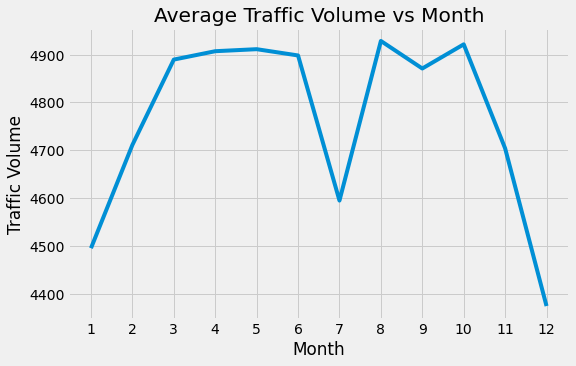

In [14]:
daytime['month'] = daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,13), by_month['traffic_volume'])
plt.xlabel('Month')
plt.ylabel('Traffic Volume')
plt.xticks(np.arange(1,13))
plt.title('Average Traffic Volume vs Month')

**Observation**:
- Traffic is less busy during winter, and it's at its lowest point in December (less than 4400 cars).
- Traffic volume gradually rises up after Januaray and then plateaus at aroun 4900 cars from March to June.
- Surprisingly, there is a dip in July and traffic increases back up to the plateau level again from August to October before a plummet in winter.

## Daytime - Traffic vs day of week

<ipython-input-15-7c137934b2ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime['dayofweek'] = daytime['date_time'].dt.dayofweek


Text(0.5, 1.0, 'Average Traffic Volume vs Month')

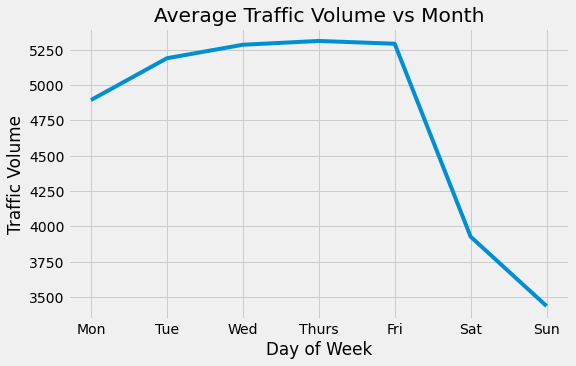

In [15]:
daytime['dayofweek'] = daytime['date_time'].dt.dayofweek
by_dayofweek = daytime.groupby('dayofweek').mean() # 0 is Monday, 6 is Sunday

plt.figure(figsize=(8,5))
plt.plot(np.arange(0, 7), by_dayofweek['traffic_volume'])
plt.xlabel('Day of Week')
plt.ylabel('Traffic Volume')
plt.xticks(np.arange(0,7),['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.title('Average Traffic Volume vs Month')


**Observations**:
- Traffic is most likely busy during weekday (about 5250 cars). Probably people commute to work.
- Traffic is exceptionally low during weekend with its lowest point on Sunday (less than 3500 cars).

## Daytime - Traffic vs time of day

We will invetigate relationship of traffice vs time of day. However traffic in weekends will drag down the average. Therefore, we will separate the dataset into 2 categories: *business days* (Mon-Fri) and *weekend* (Sat and Sun) 

In [16]:
business_days = daytime.copy()[daytime['dayofweek'] <= 4] # 4 == Friday
weekends = daytime.copy()[daytime['dayofweek'] > 4]

business_days

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,month,dayofweek
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9,10,1
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,10,1
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11,10,1
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12,10,1
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
48143,None,285.00,0.0,0.0,40,Clouds,scattered clouds,2018-09-28 14:00:00,5193,14,9,4
48144,None,285.14,0.0,0.0,40,Clouds,scattered clouds,2018-09-28 15:00:00,5838,15,9,4
48145,None,285.33,0.0,0.0,40,Clouds,scattered clouds,2018-09-28 16:00:00,6188,16,9,4
48146,None,285.24,0.0,0.0,75,Clouds,broken clouds,2018-09-28 17:00:00,5695,17,9,4


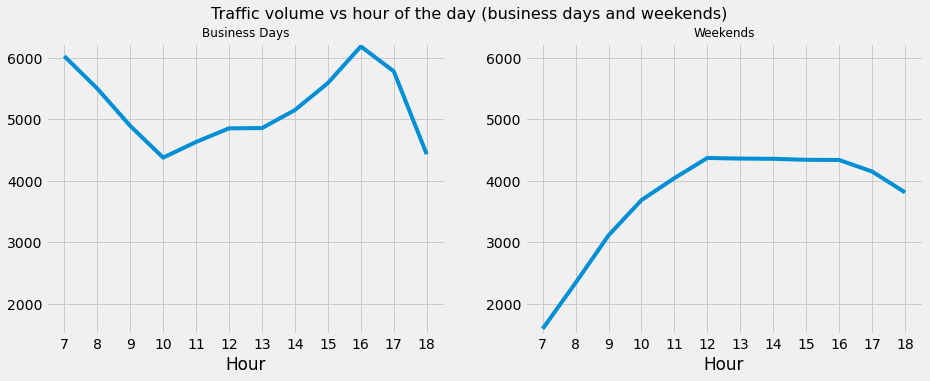

In [17]:
by_hour_business = business_days.groupby('hour').mean()
by_hour_weekends = weekends.groupby('hour').mean()

fig = plt.figure(figsize=(14,5))
fig.suptitle('Traffic volume vs hour of the day (business days and weekends)', fontsize=16)

fig.add_subplot(1,2,1)
plt.plot(by_hour_business.index, by_hour_business['traffic_volume'])
plt.title('Business Days', fontsize=12)
plt.xlabel('Hour')
plt.ylim([1500, 6250])
plt.xticks(by_hour_business.index);

fig.add_subplot(1,2,2)
plt.plot(by_hour_weekends.index, by_hour_weekends['traffic_volume'])
plt.title('Weekends', fontsize=12)
plt.xlabel('Hour')
plt.ylim([1500, 6250])
plt.xticks(by_hour_business.index);



**Observations**:
Overall, the traffic during business days is way busier than that of during weekends. 

- During weekdays: 
    - Traffic is __heaviest__, on average of **6000 cars**) in early morning (around 7AM). This is probably when people are commuting to work.
    - Traffic rapidly plummets down to about **4400 cars** from **7AM to 10AM**.
    - It slowly goes up to **4800 cars** at **1PM** following by a **sharp rise** after **1PM** and it reaches its **peak** at **4PM (nearly 6250 cars)**. This is probably the rush hour when people are heading home.
    - After rush hours, traffic volume **decreases significantly** after **5PM** to fewer than **4500 cars at 6PM**.
    
- During weekends:
    - The traffic trend in weekends is reversed.
    - Traffic **slowly rises** from **7AM to lunch time** and then **levels off** from **12PM to 4PM** at around **4400 cars** following by a **gradual drop** after **4PM**.
 

We now move on investigating the correlation between traffic_volume and some numerical features in the dataset

## Extract numerical weather columns

In [18]:
daytime_numerical = daytime.select_dtypes(include=['int64', 'float64'])
daytime_numerical = daytime_numerical.drop(['hour', 'month', 'dayofweek'], axis=1)

In [19]:
daytime_numerical.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,288.28,0.0,0.0,40,5545
1,289.36,0.0,0.0,75,4516
2,289.58,0.0,0.0,90,4767
3,290.13,0.0,0.0,90,5026
4,291.14,0.0,0.0,75,4918


### Correlation between numerical weather columns and traffice volume

In [20]:
corr_mat = daytime_numerical.corr()
corr_mat['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

Temperature has the strongest correlation with traffic volume. we will generate a scatter plot showing temp vs traffic

Text(0.5, 1.0, 'Traffic Volume vs Temperature (K)')

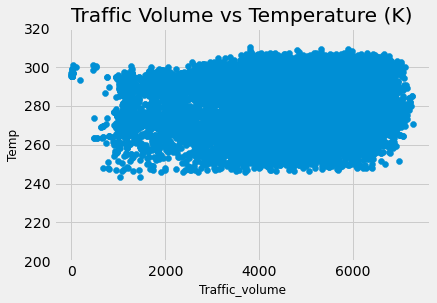

In [21]:
plt.scatter(daytime['traffic_volume'], daytime['temp'])
plt.ylim([200, 320])
plt.xlabel('Traffic_volume', fontsize=12)
plt.ylabel('Temp', fontsize=12)
plt.title('Traffic Volume vs Temperature (K)')

It does not seem that temperature has any impacts on the amount of traffic. Hence temperature is not heavy traffic indicator.
Although the correlations tell us that other numerical weather columns do not have any linear relationship with traffic, we still examine the effects of these columns on traffic volume.

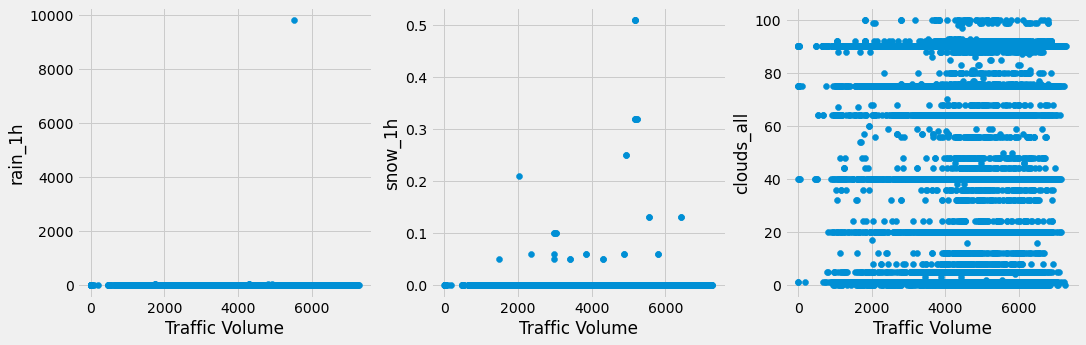

In [22]:
cols = ['rain_1h', 'snow_1h', 'clouds_all']
fig = plt.figure(figsize=(16,5))
for i, col in enumerate(cols):
    fig.add_subplot(1,len(cols), i + 1)
    plt.scatter(daytime['traffic_volume'], daytime[col])
    plt.ylabel(col)
    plt.xlabel('Traffic Volume')

The plots do not provide us any use information.

## Examine categorical weather columns 

We will focus on 2 columns: **weather_main** and **weather_description**. 

We first print out all unique values and their counts for each columns.

In [23]:
daytime['weather_main'].value_counts()

Clouds          8702
Clear           5744
Rain            2841
Mist            2593
Snow            1454
Drizzle          883
Haze             834
Thunderstorm     451
Fog              362
Smoke             12
Squall             1
Name: weather_main, dtype: int64

In [24]:
daytime['weather_description'].value_counts()

sky is clear                           4892
broken clouds                          2793
mist                                   2593
overcast clouds                        2585
scattered clouds                       2181
light rain                             1707
few clouds                             1143
light snow                              978
Sky is Clear                            852
haze                                    834
moderate rain                           785
light intensity drizzle                 573
fog                                     362
heavy snow                              320
proximity thunderstorm                  303
drizzle                                 278
heavy intensity rain                    219
snow                                    137
proximity shower rain                   111
thunderstorm                             48
heavy intensity drizzle                  29
thunderstorm with heavy rain             25
thunderstorm with light rain    

We are going to calculate the average traffic volume associated with each unique value in these 2 columns and generate bar plots.

Text(0.5, 1.0, 'Traffic Volume vs Weather Main')

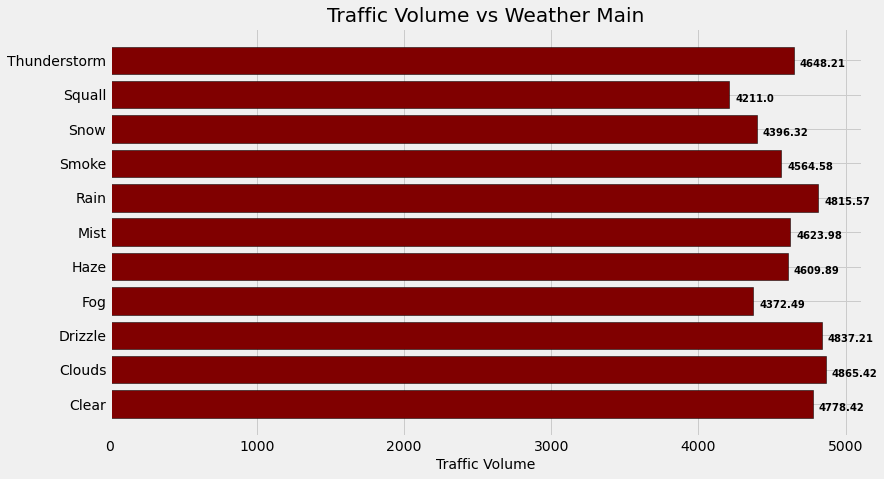

In [25]:
by_weather_main = daytime.groupby('weather_main').mean()
by_weather_description = daytime.groupby('weather_description').mean()

plt.figure(figsize=(12,7))
ax = plt.barh(by_weather_main.index, by_weather_main['traffic_volume'], edgecolor='black', color='maroon')

for i in ax.patches:
    plt.text(i.get_width()+40, i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='black')
plt.xlabel('Traffic Volume', fontsize=14)
plt.title("Traffic Volume vs Weather Main")

Text(0.5, 1.0, 'Traffic Volume vs Weather Description')

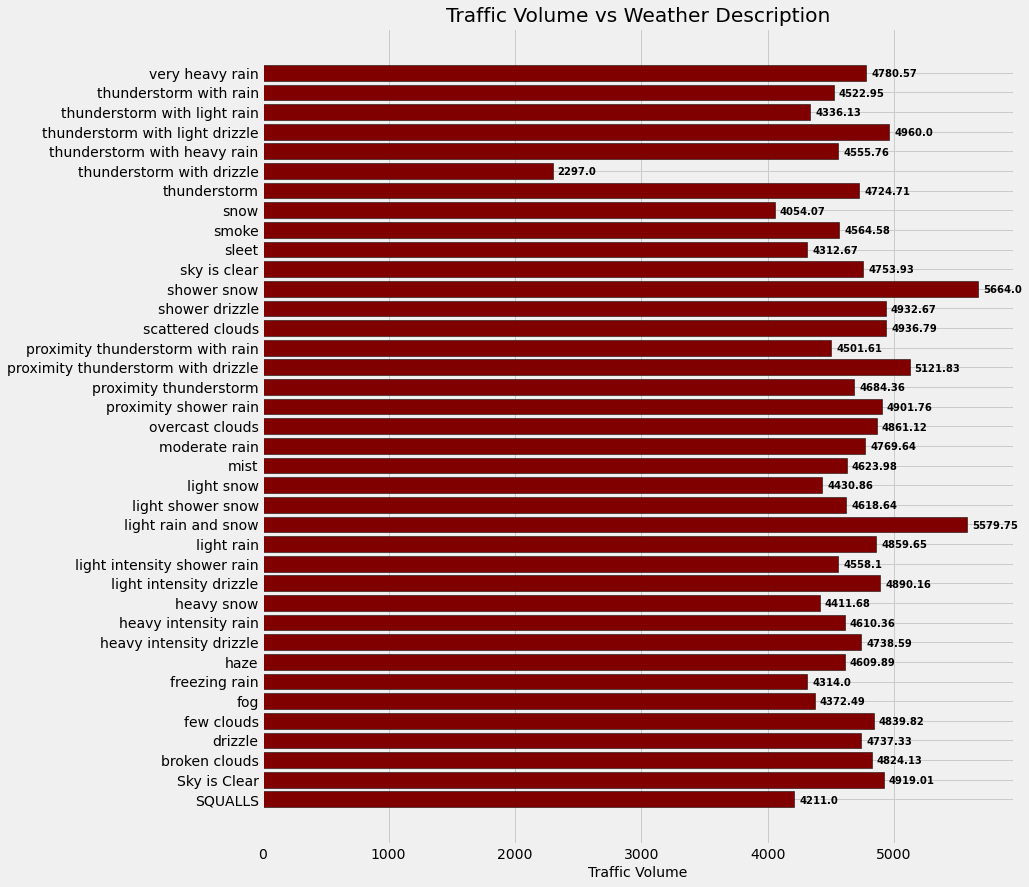

In [26]:
plt.figure(figsize=(12,14))
ax = plt.barh(by_weather_description.index, by_weather_description['traffic_volume'], edgecolor='black', color='maroon')

for i in ax.patches:
    plt.text(i.get_width()+40, i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='black')
    
plt.xlabel('Traffic Volume', fontsize=14)
#plt.yticks(rotation=30)
plt.title("Traffic Volume vs Weather Description")

From the **weather_main** bar plots, there are not many variances in the traffic volume counts w.r.t weather conditions. Hence we don't learn any insights from this bar plot.

On the other hand, the **weather_description** bar plots provide us more interesting information:
- The weather conditions that seem to cause heaviest traffic are **shower snow** (5664 cars), **proximity thunderstorm with drizzle** (5122 cars), and **light rain and snow** (5579 cars). This is quite counterintuitive that people most likely get on the road under foul weather.

- People seems to avoid the road under **thunderstorm with drizzle** (only 2297 cars on average).

## Examine Holiday

In [27]:
traffic['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
New Years Day                    6
Martin Luther King Jr Day        6
Christmas Day                    6
Veterans Day                     5
Columbus Day                     5
State Fair                       5
Memorial Day                     5
Washingtons Birthday             5
Independence Day                 5
Name: holiday, dtype: int64

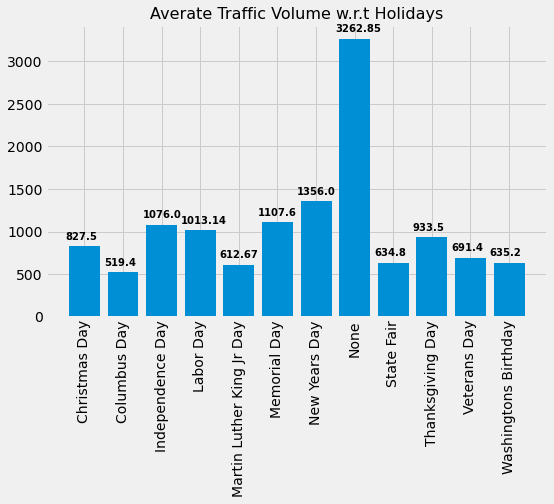

In [61]:
by_holiday = traffic.groupby('holiday').mean()
plt.figure(figsize=(8,5))
ax = plt.bar(by_holiday.index, by_holiday['traffic_volume'])
plt.xticks(rotation=90)
plt.title("Averate Traffic Volume w.r.t Holidays", fontsize=16)
for i in ax.patches:
    plt.text(i.get_x() - 0.1 , i.get_height() + 80,
             str(round((i.get_height()), 2)),
             fontsize=10, fontweight='bold'
            )

## Conclusion

We have found the following heavy traffic indicators on I-94:

- Traffic is heavier during **daytime** than nighttime.
- Spring and summer/fall season: from **March to June** and **August to October**.
- Business days (from Mon to Fri).
- During business days, early morning (7AM) and rush hours (from 4PM to 6PM).
- During weekends, from 12PM to 4PM
- Some foul weathers such as: shower snow, proximity thunderstorm with drizzle, light rain and snow.
- Non-Holiday